## In this notebook we create our model and evaluate it

**Model Steps:**

1. Run PCA on the preprocessed data

2. Use the elbow method to find a k value

3. Run kmeans with the dataframe created in the PCA step



# Set up and load data

In [1]:
import time

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import polars as pl
import seaborn as sns
from sklearn.cluster import KMeans, HDBSCAN
from sklearn.decomposition import PCA
from sklearn.metrics import silhouette_score
from umap import UMAP

RANDOM_STATE = 42

C:\Users\User\anaconda3\envs\music-recommender\Lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
# if local
processed_users_path = "data/users_cleaned_df_encoded.parquet"
songs_path = "data/songs_df_full.csv"

In [3]:
# # if google colab
# processed_users_path = "/content/drive/MyDrive/DSE/DSE 220 Final Project/Data/users_cleaned_df_encoded.parquet"
# songs_path = "/content/drive/MyDrive/DSE/DSE 220 Final Project/Data/songs_df_full.csv"
# from google.colab import drive
#
# drive.mount('/content/drive')

ModuleNotFoundError: No module named 'google'

In [62]:
# Polars is faster at loading large datasets
users_polars_df = pl.read_parquet(processed_users_path)

In [63]:
# This conversion can take 51s on regular ram, 21 seconds on high ram mode
users_df_orig = users_polars_df.to_pandas(use_pyarrow_extension_array=True)

In [64]:
len(users_df_orig)

574660

In [65]:
users_df = users_df_orig.copy().sample(
    n=50000,
    random_state=RANDOM_STATE
)

In [66]:
# Drop all one hot encoded fav artist columns (takes too long to run)
users_df = users_df[users_df.columns.drop(list(users_df.filter(regex='fav_artist_')))]
len(users_df)

50000

## Dimensional Reduction

### PCA for k-means
Run PCA and capture at least 90% of the variance.

In [68]:
# Want to keep at least 90% of the variance
transformer = PCA(n_components=0.9, random_state=RANDOM_STATE)

In [69]:
# Drop user_id as it will not have relevance for clustering
X = users_df.drop(columns=['user_id'])

In [70]:
X_pca = transformer.fit_transform(X)

In [71]:
# Create new columns for each of the components
num_cols = X_pca.shape[1]
X_pca_df = pd.DataFrame(
    X_pca,
    columns=[f'PC{i + 1}' for i in range(num_cols)]
)
X_pca_df.head()

,PC1,PC2,PC3,PC4,PC5,PC6,PC7,PC8
0,4.586625,1.485456,-0.648893,1.089531,-1.709135,-0.657414,0.138866,-0.520494
1,1.975783,0.660841,0.192893,-0.722606,-0.307801,-1.580758,0.356170,0.595286
2,-1.924186,0.108552,0.381815,0.143936,0.145217,0.449932,0.107586,-0.435524
3,0.873210,-1.635013,-0.043897,0.869662,-0.547383,-0.154664,-0.381452,0.159759
4,-2.067530,-0.602932,0.859343,-0.732304,0.293045,0.536605,0.318872,-0.050730


In [72]:
print("Explained variance ratio by each component:", transformer.explained_variance_ratio_)
print("Total variance captured:", np.sum(transformer.explained_variance_ratio_))

Explained variance ratio by each component: [0.38832168 0.25130598 0.08405851 0.07222983 0.06321842 0.02045785
 0.01819206 0.01541443]
Total variance captured: 0.9131987559438466


### UMAP for HDBSCAN

In [73]:
# todo: move

# Model Creation & Evaluation

## Model 1: K Means

### Picking K: Elbow method
Use elbow method and a plot to see how many clusters we should use.

In [74]:
n_clusters = 30  # how many clusters to test
k_values = range(1, n_clusters + 1)
inertia_values = []
# store the number of data points within each cluster for every k tested
kmeans_comp_arr = np.zeros((n_clusters, n_clusters))

for k in k_values:
    kmeans = KMeans(n_clusters=k, random_state=RANDOM_STATE, n_init='auto')
    kmeans_fitted = kmeans.fit(X_pca_df)
    inertia_values.append(kmeans.inertia_)
    # unique cluster labels assigned to each data point, counts points in cluster
    cluster_id, counts = np.unique(kmeans_fitted.labels_, return_counts=True)
    for i in range(len(cluster_id)):
        kmeans_comp_arr[k - 1, cluster_id[i]] = counts[i]

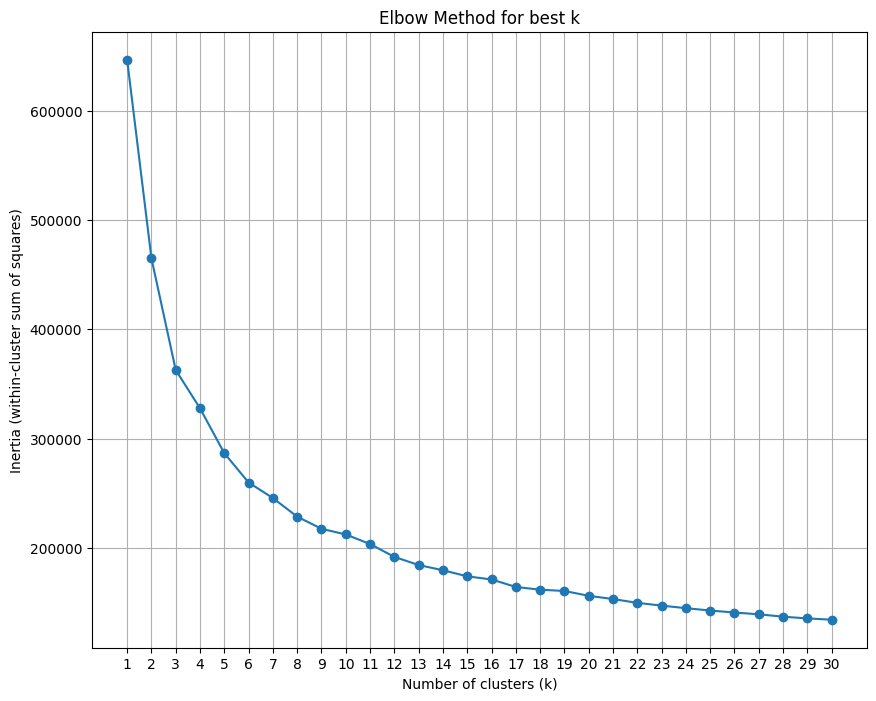

In [75]:
# Plot the elbow
plt.figure(figsize=(10, 8))
plt.plot(k_values, inertia_values, marker='o')
plt.xticks(k_values)
plt.xlabel('Number of clusters (k)')
plt.ylabel('Inertia (within-cluster sum of squares)')
plt.title('Elbow Method for best k')
plt.grid(True)
plt.show()

In [76]:
kmeans_comp_df = pd.DataFrame(
    kmeans_comp_arr,
    index=k_values,
    columns=[f'Cluster {i}' for i in range(n_clusters)]
)

print("Distribution of data points per cluster for each k (rows = k, columns = cluster ID):")
display(kmeans_comp_df.head(10))

Distribution of data points per cluster for each k (rows = k, columns = cluster ID):


,Cluster 0,Cluster 1,Cluster 2,Cluster 3,Cluster 4,Cluster 5,Cluster 6,Cluster 7,Cluster 8,Cluster 9,...,Cluster 20,Cluster 21,Cluster 22,Cluster 23,Cluster 24,Cluster 25,Cluster 26,Cluster 27,Cluster 28,Cluster 29
1,50000.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,38761.0,11239.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,5229.0,7934.0,36837.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,5684.0,7607.0,31765.0,4944.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
5,4996.0,3036.0,27176.0,4123.0,10669.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
6,4789.0,2709.0,25722.0,1046.0,9267.0,6467.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
7,4625.0,2680.0,25049.0,1039.0,9387.0,6412.0,808.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
8,4070.0,4707.0,5572.0,5119.0,19186.0,8896.0,1478.0,972.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
9,3924.0,4467.0,2897.0,6443.0,17880.0,4604.0,1501.0,551.0,7733.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
10,3773.0,4340.0,2435.0,6202.0,12393.0,8641.0,1475.0,520.0,7481.0,2740.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


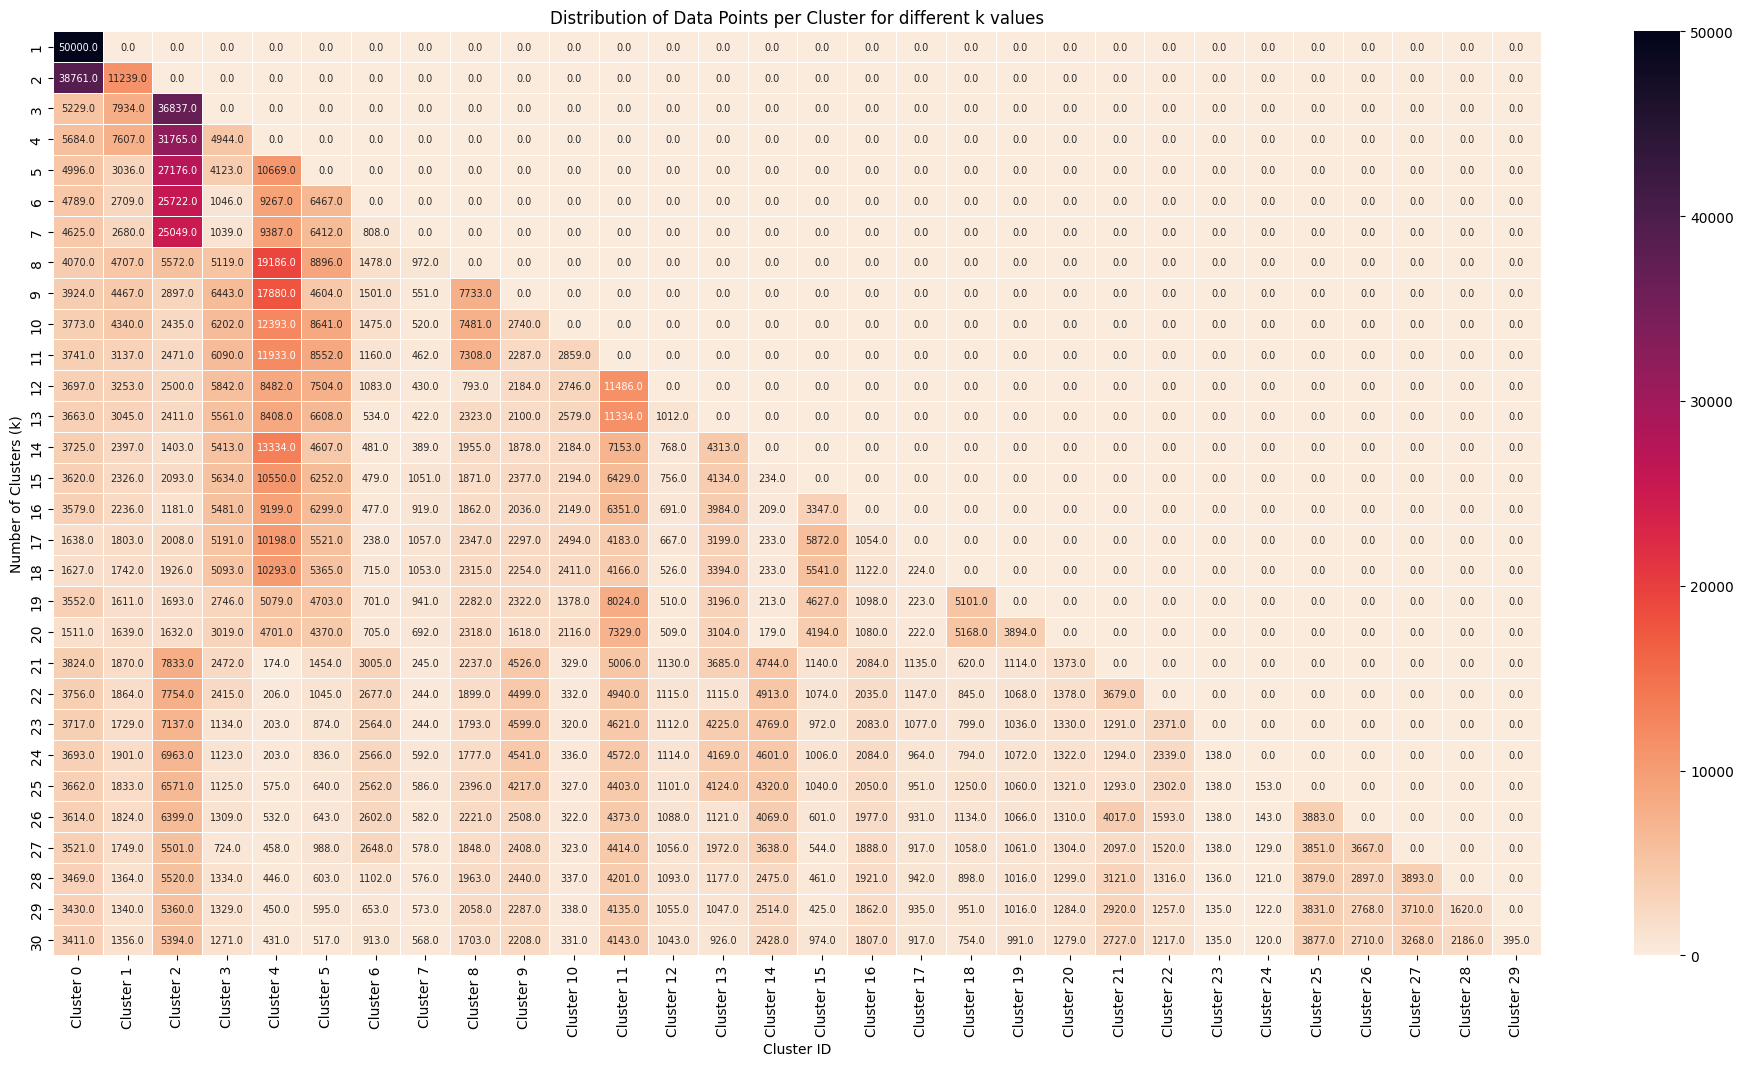

In [77]:
plt.figure(figsize=(24, 12))
sns.heatmap(kmeans_comp_df,
            annot=True,
            fmt='.1f',
            cmap='rocket_r',
            annot_kws={'fontsize': 7},
            linewidths=0.5
            )
plt.title('Distribution of Data Points per Cluster for different k values')
plt.xlabel('Cluster ID')
plt.ylabel('Number of Clusters (k)')
plt.show()

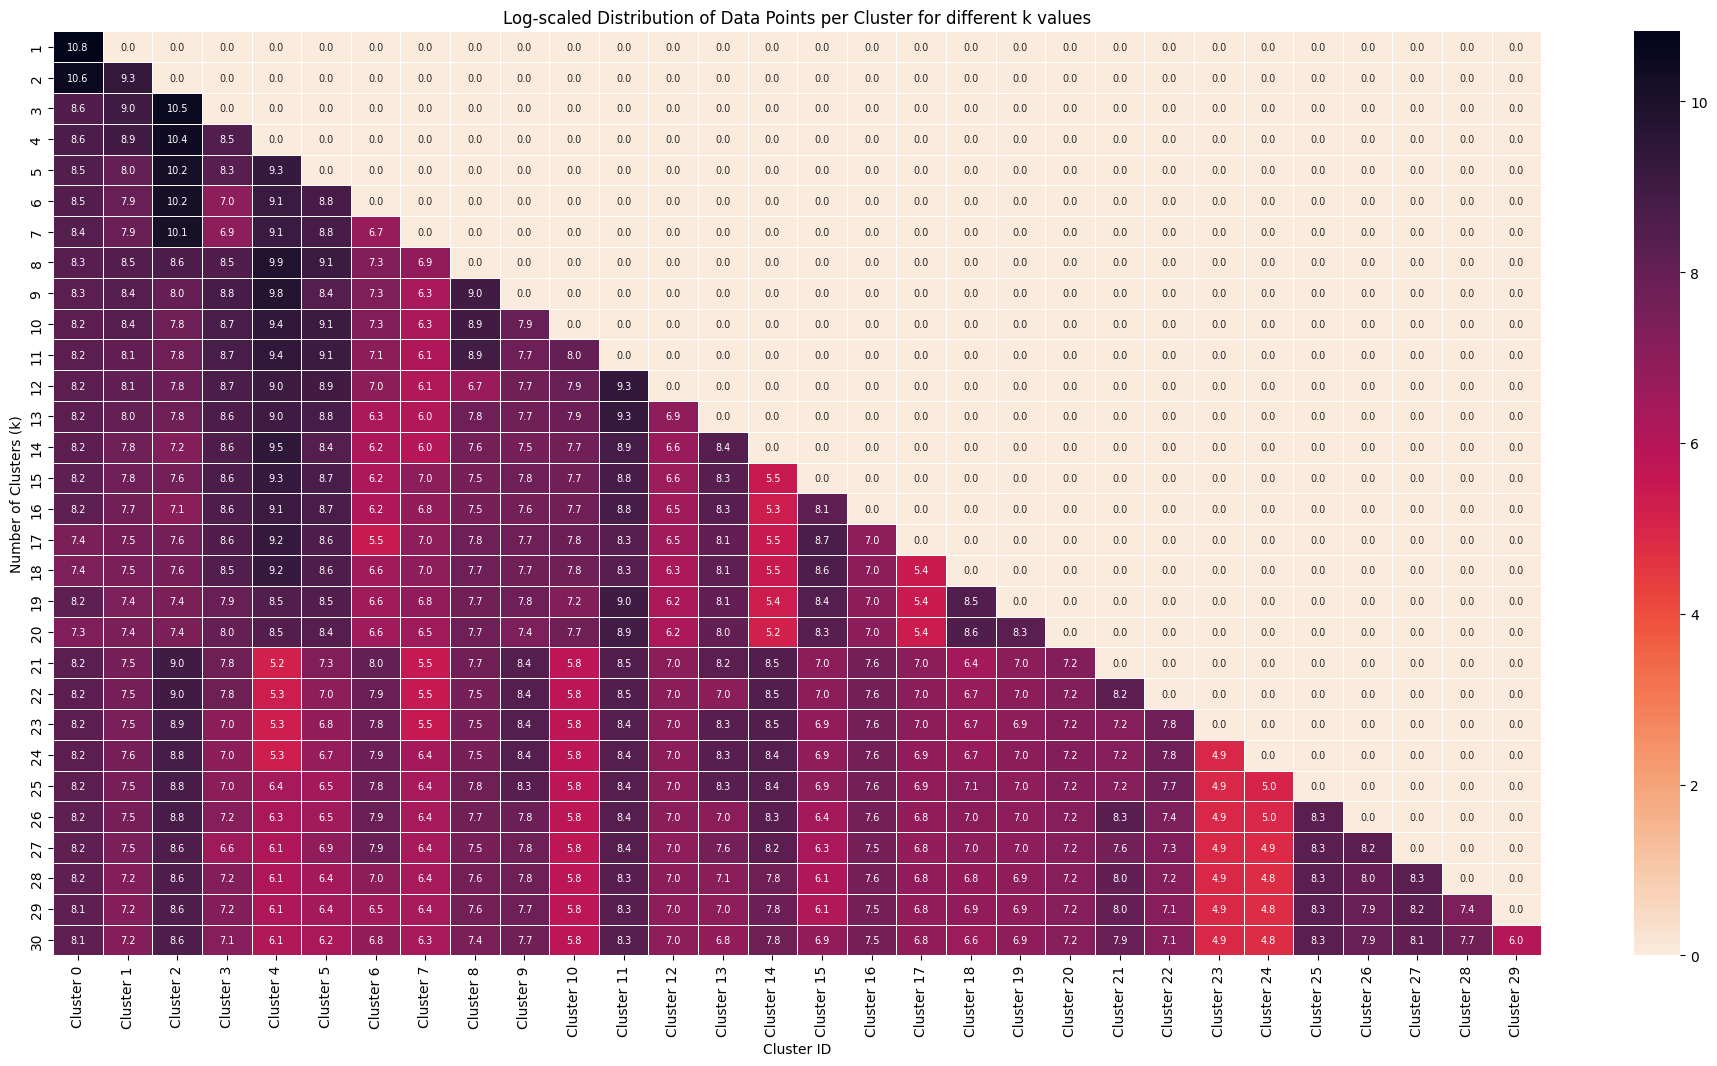

In [78]:
plt.figure(figsize=(24, 12))
sns.heatmap(np.log1p(kmeans_comp_df), annot=True, fmt='.1f', cmap='rocket_r', annot_kws={'fontsize': 7}, linewidths=0.5)
plt.title('Log-scaled Distribution of Data Points per Cluster for different k values')
plt.xlabel('Cluster ID')
plt.ylabel('Number of Clusters (k)')
plt.show()

### Run k-means

In [79]:
# Based on the elbow, we observe a leveling out at k=9
k_num_clusters = 26

In [80]:
kmeans = KMeans(n_clusters=k_num_clusters, random_state=RANDOM_STATE, n_init='auto')
kmeans_fitted = kmeans.fit(X_pca_df)
inertia_values.append(kmeans.inertia_)
np.unique(kmeans_fitted.labels_, return_counts=True)

(array([ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15, 16,
        17, 18, 19, 20, 21, 22, 23, 24, 25], dtype=int32),
 array([3614, 1824, 6399, 1309,  532,  643, 2602,  582, 2221, 2508,  322,
        4373, 1088, 1121, 4069,  601, 1977,  931, 1134, 1066, 1310, 4017,
        1593,  138,  143, 3883]))

### Evaluate k-means

In [103]:
users_clustered_df = users_df.copy()
users_clustered_df['kmeans_cluster'] = kmeans_fitted.labels_

In [81]:
# Compute Silhouette Score to measure cluster similarity
# It's costly to run, so we sample with 100k
sample = np.random.choice(len(X_pca_df), size=50000, replace=False)
score = silhouette_score(X_pca_df.iloc[sample], kmeans_fitted.labels_[sample])
print("Silhouette Score (sample):", score)

Silhouette Score (sample): 0.13902833305681442


In [82]:
# For PCA Plots
users_columns_pca = X_pca_df.columns
users_centroids_pca = kmeans_fitted.cluster_centers_
users_kmeans_centroids_df = pd.DataFrame(columns=users_columns_pca, data=users_centroids_pca)
users_kmeans_centroids_df['kmeans_cluster'] = users_kmeans_centroids_df.index

users_df_kmeans_clusters = X_pca_df.copy()
users_df_kmeans_clusters['kmeans_cluster'] = kmeans_fitted.labels_
users_df_kmeans_clusters['user_id'] = users_df['user_id']

In [83]:
users_kmeans_centroids_df.head(5)

,PC1,PC2,PC3,PC4,PC5,PC6,PC7,PC8,kmeans_cluster
0,-1.845227,-0.518235,-1.377924,-0.282417,-0.129791,0.013783,-0.052162,0.032291,0
1,3.957026,-1.129891,0.123795,-0.179755,-0.871153,-0.078937,0.044913,0.027472,1
2,-1.752878,-0.704255,0.534623,-0.409139,0.054549,0.335428,0.227076,-0.048376,2
3,-1.155276,0.349523,-0.359077,2.756786,-0.226765,-0.063173,0.079825,-0.022553,3
4,2.190545,8.247232,-0.124918,-0.267154,0.401881,0.560476,-0.536330,0.209568,4


In [84]:
# For visualizing using original features
users_df_clusters_orig = users_df.copy()
users_df_clusters_orig['kmeans_cluster'] = kmeans_fitted.labels_
users_df_clusters_orig['user_id'] = users_df['user_id']

In [85]:
users_df_kmeans_clusters['kmeans_cluster'].value_counts().sort_index()

,count
kmeans_cluster,
0,3614
1,1824
2,6399
3,1309
4,532
5,643
6,2602
7,582
8,2221


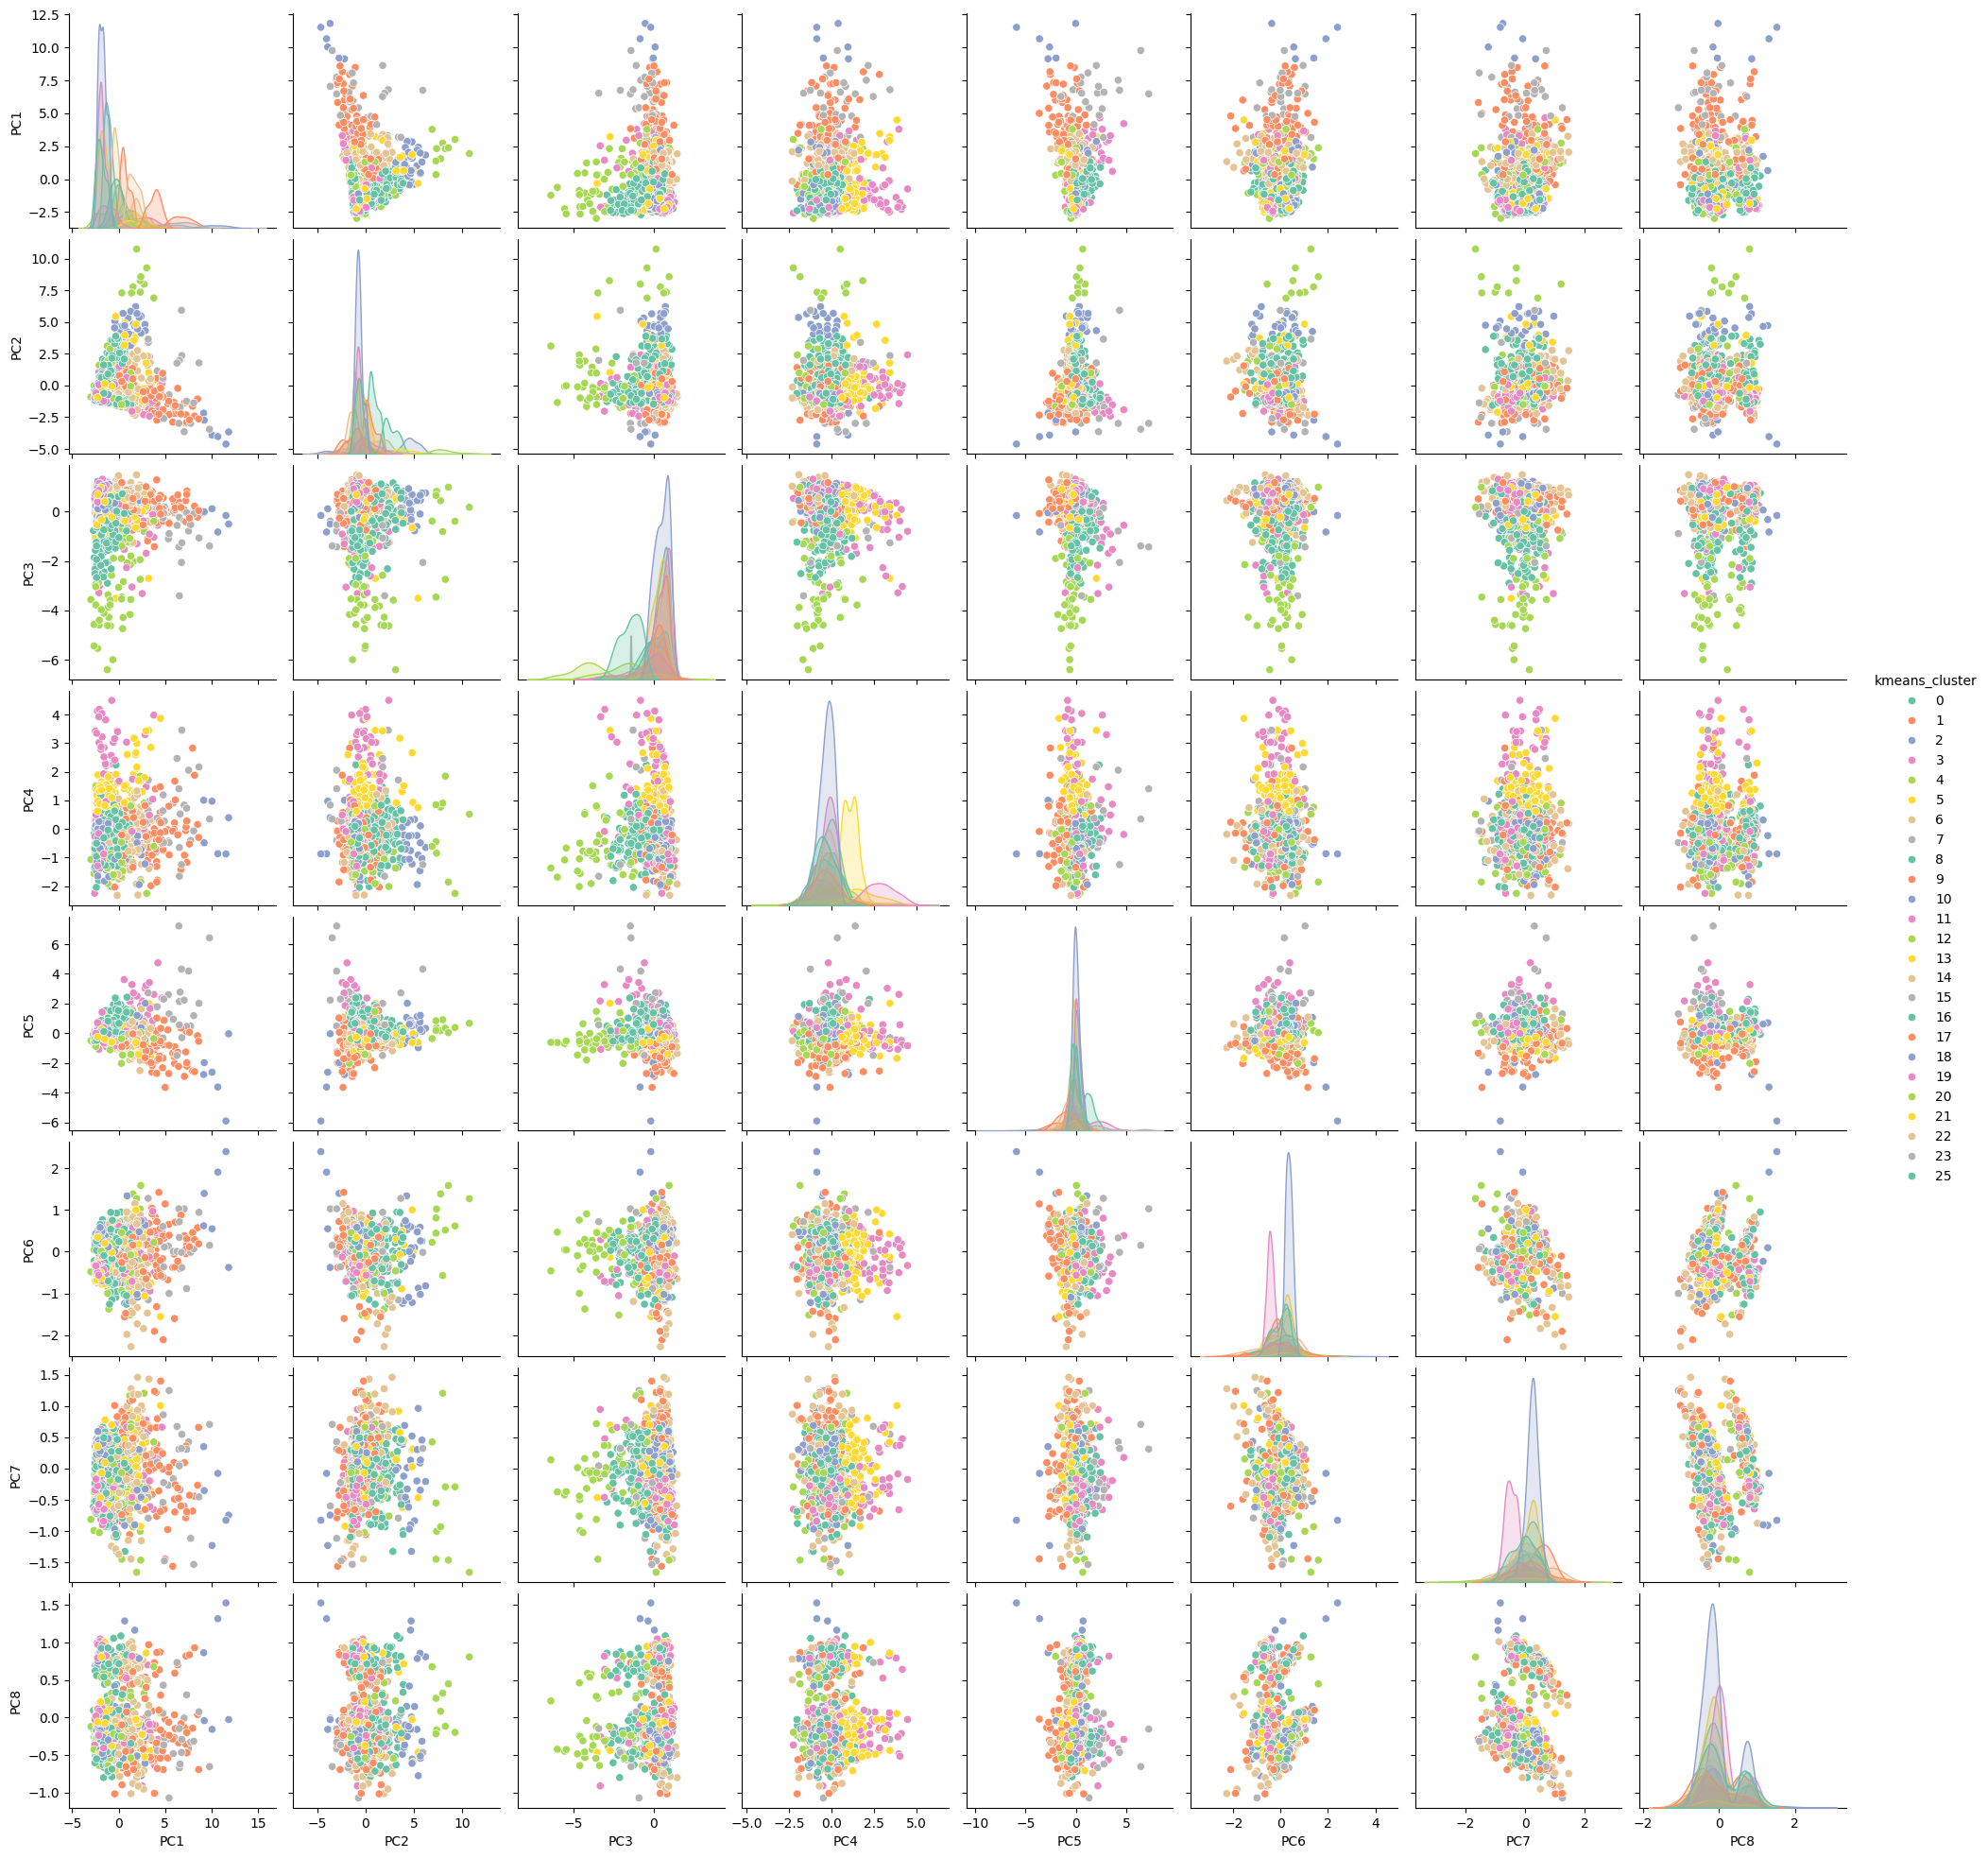

In [86]:
# How are clusters distinguished across different PC features?
sns.pairplot(
    hue='kmeans_cluster',
    palette='Set2',
    data=users_df_kmeans_clusters.sample(
        n=1000,
        random_state=RANDOM_STATE
    )
)

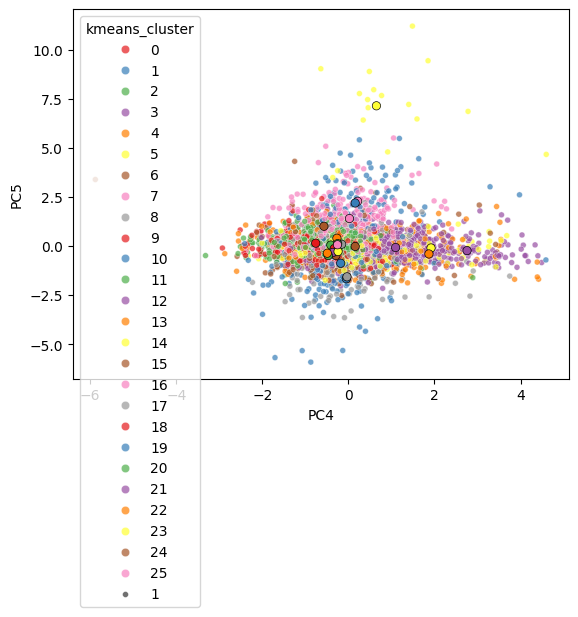

In [88]:
# Inspect a designated pc space more closely (look at pairplots for general overview)
# Also shows the centroids
variable_pairs = ['PC4', 'PC5']

# Plotting the results
sns.scatterplot(
    x=variable_pairs[0],
    y=variable_pairs[1],
    hue='kmeans_cluster',
    palette='Set1',
    size=1, alpha=0.7,
    data=users_df_kmeans_clusters.sample(
        n=5000,
        random_state=RANDOM_STATE
    )
)

sns.scatterplot(
    x=variable_pairs[0],
    y=variable_pairs[1],
    hue='kmeans_cluster',
    palette='Set1',
    markers=1000,
    alpha=1,
    edgecolor="black",
    data=users_kmeans_centroids_df,
    legend=False
)
plt.show()

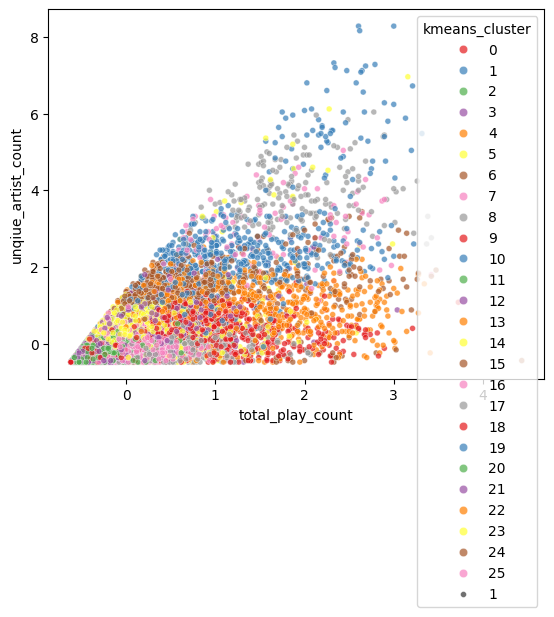

In [90]:
# To show that our current model is not separating just on play count and play time
# We can see this because it is not neatly separated on these 2 features alone (like it was with just numerical values)
variable_pairs = ['total_play_count', 'unqiue_artist_count']
# Plotting the results
sns.scatterplot(
    x=variable_pairs[0],
    y=variable_pairs[1],
    hue='kmeans_cluster',
    palette='Set1',
    size=1, alpha=0.7,
    data=users_df_clusters_orig.sample(n=10000, random_state=RANDOM_STATE)
)
plt.show()

## Model 2: HDBSCAN
Density based clustering

*   We noticed in a previous milestone that we had clusters with very few data points, so we wanted to try density based clustering to remedy this.
*   DBSCAN groups points that are closely packed together (many nearby neighbors)
*   Outliers in low-desnity regions are marked



Faizan's Colab (CPU with High RAM)

n= 100000

- x_map time: 1 minute
- hdbscan time: 93 sec


n= 200000
- x_map time: 130 sec
- hdbscan time:  458.84 seconds


n= 300000
- x_map time: 209.01 seconds
- hdbscan time:  1081.89 seconds

### UMAP

In [91]:
# hdbscan = O(n^2) = takes too long to run on full dataset
X_hdbscan = users_df.drop(columns=['user_id'])

In [92]:
print("Starting UMAP for HDBSCAN...")
start_time = time.time()
# works better than pca for hdbscan
X_umap = UMAP(
    n_components=15,  # number of dimensions to reduce to
    n_neighbors=50,  # number of nearest neighbors to use in manifold approximation
    min_dist=0.0,  # how tightly packed the manifold is within local neighborhood
).fit_transform(X_hdbscan)

end_time = time.time()
print(f"UMAP completed in {end_time - start_time:.2f} seconds")

Starting UMAP for HDBSCAN...
UMAP completed in 35.12 seconds


In [93]:
print(X_umap.shape)

(50000, 15)


In [94]:
X_umap

array([[6.0554795, 7.9157896, 6.2567725, ..., 5.586123 , 6.100658 ,
        3.2566864],
       [7.203679 , 6.8638754, 6.772453 , ..., 5.5983515, 6.1656933,
        3.2340572],
       [8.435844 , 6.6256423, 2.2589445, ..., 5.5395613, 5.7405066,
        3.075146 ],
       ...,
       [8.90695  , 6.994638 , 9.268497 , ..., 5.5559583, 6.0925956,
        3.2236931],
       [7.97201  , 7.1813893, 6.655818 , ..., 5.6059484, 5.871491 ,
        3.0760906],
       [7.7636704, 6.4862704, 7.44621  , ..., 5.5746145, 6.20705  ,
        3.2345448]], dtype=float32)

### Run HDBSCAN

In [95]:
print("Starting HDBSCAN...")
start_time = time.time()

hdb_labels = HDBSCAN(
    min_cluster_size=200,  # of points in a group are valid to be a cluster, any less is noise
    min_samples=10,  # controls how strict "core" points are
    n_jobs=-1  # use all cores
).fit_predict(X_umap)

end_time = time.time()
print(f"HDBSCAN completed in {end_time - start_time:.2f} seconds")

Starting HDBSCAN...
HDBSCAN completed in 33.42 seconds


In [104]:
users_clustered_df["hdb_cluster"] = hdb_labels

In [97]:
print(len(users_df["hdb_cluster"].unique()), "clusters")
users_df["hdb_cluster"].value_counts()
# 35k "-1"  with min_cluster_size=20, min_samples=10
# 36k "-1"  with min_cluster_size=20, min_samples=5

38 clusters


,count
hdb_cluster,
-1,17566
23,4290
19,3294
24,2841
27,1818
33,1763
32,1725
21,1435
0,1375


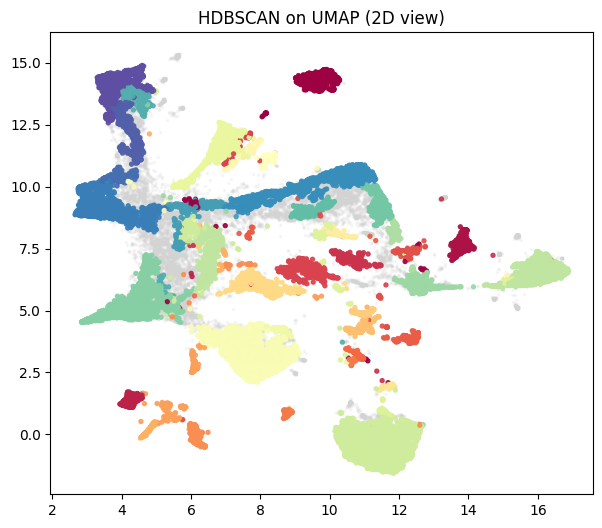

In [98]:
# ai slop
X_umap_2d = UMAP(
    n_components=2,
    n_neighbors=30,
    min_dist=0.0,
).fit_transform(X_hdbscan)
plot_df = pd.DataFrame(X_umap_2d, columns=["UMAP1", "UMAP2"])
plot_df["hdb_cluster"] = labels

noise = plot_df[plot_df["hdb_cluster"] == -1]
clusters = plot_df[plot_df["hdb_cluster"] != -1]

plt.figure(figsize=(7, 6))

# noise first, light gray
plt.scatter(
    noise["UMAP1"], noise["UMAP2"],
    c="lightgray", s=2, alpha=0.15
)

# clusters on top
plt.scatter(
    clusters["UMAP1"], clusters["UMAP2"],
    c=clusters["hdb_cluster"], cmap="Spectral",
    s=8, alpha=0.9
)

plt.title("HDBSCAN on UMAP (2D view)")
plt.show()

### Evaluate HDBSCAN

<Axes: xlabel='hdb_cluster', ylabel='Count'>

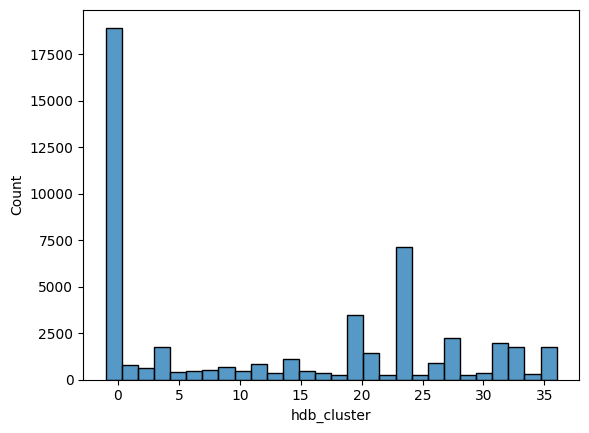

In [102]:
# users_df["hdb_cluster"].hist()
sns.histplot(users_df['hdb_cluster'])

In [100]:
# sns.pairplot(
#     hue='hdb_cluster',
#     palette='Set2',
#     data=users_df.sample(
#         n=1000,
#         random_state=RANDOM_STATE
#     )
# )

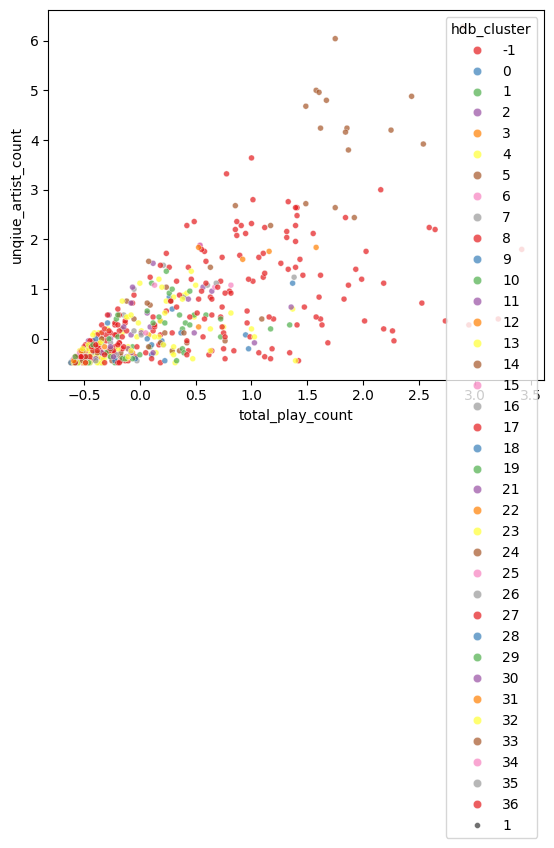

In [101]:
# To show that our current model is not separating just on play count and play time
# We can see this because it is not neatly separated on these 2 features alone (like it was with just numerical values)
variable_pairs = ['total_play_count', 'unqiue_artist_count']
# Plotting the results
sns.scatterplot(
    x=variable_pairs[0],
    y=variable_pairs[1],
    hue='hdb_cluster',
    palette='Set1',
    size=1, alpha=0.7,
    data=users_df.sample(n=500, random_state=RANDOM_STATE)
)
plt.show()

### Save Cluster Assignments

In [105]:
users_clustered_df.describe()

,total_play_count,total_play_time,unqiue_artist_count,unqiue_song_count,fav_maj_count,fav_min_count,fav_year,year_count,fav_song_plays,fav_song_duration,tot_fav_song_play_time,hdb_cluster,kmeans_cluster
count,50000.0,50000.0,50000.0,50000.0,50000.0,50000.0,50000.0,50000.0,50000.0,50000.0,50000.0,50000.000000,50000.000000
mean,0.267126,0.266331,0.3834,0.3834,0.381386,0.343867,-0.416683,0.31993,0.392007,0.132213,0.416102,12.556400,11.325200
std,0.814492,0.808481,1.037038,1.037038,1.170231,1.336257,1.087425,0.821994,1.277558,0.988827,1.313452,12.926249,7.917948
min,-0.618421,-0.683526,-0.48,-0.48,-0.785714,-0.666667,-11.0,-0.666667,-0.636364,-2.711248,-0.656381,-1.000000,0.000000
25%,-0.355263,-0.351582,-0.32,-0.32,-0.357143,-0.333333,-0.714286,-0.333333,-0.363636,-0.460562,-0.333025,-1.000000,3.000000
50%,0.0,-0.001485,0.0,0.0,0.0,0.0,0.0,0.0,0.0,-0.007545,-0.005471,12.000000,11.000000
75%,0.644737,0.651809,0.68,0.68,0.642857,0.666667,0.285714,0.666667,0.636364,0.533693,0.644225,24.000000,18.000000
max,4.434211,2.960989,8.6,8.6,13.0,26.333333,0.571429,8.666667,33.727273,4.763031,20.427824,36.000000,25.000000


In [116]:
u_c_columns = ['user_id', 'hdb_cluster', 'kmeans_cluster']
users_clustered_df = users_clustered_df[u_c_columns]

In [117]:
users_clustered_df.head()

,user_id,hdb_cluster,kmeans_cluster
4046,01d700a298cc9ed716949c6777ab7407547808b6,-1,15
159880,477577673ad2fa857be4901f40592cf08c4f1a29,-1,22
285712,7f274b4fe23282894a14f67b3151279e21c247ea,23,2
381459,a9f2f1414bbfe0bca8e87c67ff03a0fee11ed36b,12,6
272634,797884772cca4aab80dd52fa4700d3ef542f4cf6,0,2


In [ ]:
# if local
users_clustered_path_parquet = "data/users_clusters_df.parquet"

In [ ]:
# if collab
users_clustered_path_parquet = "/content/drive/MyDrive/DSE/DSE 220 Final Project/Data/users_clusters_df.parquet"

In [115]:
# Save the processed dataframe to Parquet
users_clustered_df.to_parquet(users_clustered_path_parquet, index=False, engine='pyarrow')
print(f"Processed DataFrame saved to: {users_clustered_path_parquet}")

Processed DataFrame saved to: /content/drive/MyDrive/DSE/DSE 220 Final Project/Data/users_with_clusters_df.parquet
